# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля.

В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# загружаем библиотеки
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import re
import seaborn as sns
import warnings

# загружаем классы для подготовки данных
from sklearn import set_config
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# загружаем библиотеки для МО
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
set_config(display="diagram")

# зафиксируем RANDOM_STATE
RANDOM_STATE = 42
# зафиксируем TEST_SIZE
TEST_SIZE = 0.25

### Загрузка данных

In [3]:
def data_import(file_name: str) -> pd.DataFrame:

    local_pth = '/datasets/' + file_name
    server_pth = 'https://example.ru/' + file_name
    
    try:
        data = pd.read_csv(local_pth, parse_dates=['DateCrawled', 'LastSeen', 'DateCreated'])
    except:
        data = pd.read_csv(server_pth, parse_dates=['DateCrawled', 'LastSeen', 'DateCreated'])
    
    return data

In [4]:
# загрузим файл и выведем первые строки
df_autos = data_import('autos.csv')
df_autos.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [5]:
# приведем названия колонок к pep-8
df_autos.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower(), inplace=True)

# выведем информацию по датафрейму
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

В данных 15 признаков с 35469 строк данных, имеются пропуски.

---
---

### Предобработка данных

#### Отбор признаков

In [6]:
# выведем уникальные значения каждого признака
df_autos.nunique()

date_crawled          271174
price                   3731
vehicle_type               8
registration_year        151
gearbox                    2
power                    712
model                    250
kilometer                 13
registration_month        13
fuel_type                  7
brand                     40
repaired                   2
date_created             109
number_of_pictures         1
postal_code             8143
last_seen             179150
dtype: int64

Есть несколько признаков, которые стоит проверить на "негодность" для МО.

<b> 1. Данные, содержащие дату </b>
    
Они не понадобятся для обучения модели. Выведем минимальные и максимальные значения каждого признака.

In [7]:
df_autos[['date_crawled', 'last_seen', 'date_created']].agg(['min', 'max'])

,date_crawled,last_seen,date_created
min,2016-03-05 14:06:22,2016-03-05 14:15:08,2014-03-10
max,2016-04-07 14:36:58,2016-04-07 14:58:51,2016-04-07


Данные выгружались в течение месяца с матра по май 2016 года. Пользователи заходили на сайт в течение этого месяца.

<b> 2. Данные почтовых индексов</b>

Это почти категориальный признак, так как почтовые индексы регламентируются. Изучим данные.

In [8]:
# кол-во записей каждого почтового индекса по убыванию
s_postal = df_autos.postal_code.value_counts().sort_values(ascending=False)
# выведем топ-5 индексов
s_postal.head()

10115    819
65428    613
66333    343
32257    317
44145    317
Name: postal_code, dtype: int64

In [9]:
print(f'Ср.кол-во пользователей на почтовый индекс: {round(s_postal.mean())}')

Ср.кол-во пользователей на почтовый индекс: 44


In [10]:
# выведем малочисленные индексы
print(f'Кол-во малочисленных почтовых индексов: {(s_postal<44).sum()}')

Кол-во малочисленных почтовых индексов: 5303


Среди всех данных пик распределения почтовых индексов равен 819 пользователям, что приблизительно равно 0.23%,
то есть данные почтовых индексов сильно распылены, ведь в среднем на 1 почтовый индекс приходится 44 пользователя.

Среди всех данных 65% почтовых индексов меньше среднего кол-ва пользователей. Этот признак можно удалить.

<b>3. Модель автомобиля</b>

Достаточно много униказьных значений модели авто (для категориального признака) - 250 значений.

In [11]:
# кол-во записей каждой модели
s_model = df_autos.model.value_counts()

# выведем кол-во моделей с менее 1000 и менее 500 записей
print(f'Кол-во моделей с менее 1000 записей: {(s_model < 1000).sum()}\
\nКол-во моделей с менее 500 записей: {(s_model < 500).sum()}')

Кол-во моделей с менее 1000 записей: 194
Кол-во моделей с менее 500 записей: 150


Таким образом 60% данных этого признака малочисленные группы. Помимо этого, название модели должно сильно коррелировать с брендом авто.

In [12]:
# выведем матрицу корреляции бренда и модели авто
df_autos[['brand', 'model']].phik_matrix()

,brand,model
brand,1.000000,0.998376
model,0.998376,1.000000


Таким образом, с учетом наличия большого количества уникальных групп и высокой корреляцией с названием бренда, можно считать этот признак избыточным и удалить его.

<b>4. Кол-во фотографий

In [13]:
df_autos.number_of_pictures.unique()

array([0], dtype=int64)

Признак `number_of_pictures` хранит в себе одно уникальное значение для всех данных, его можно удалить.

In [14]:
# удалим неинформативные признаки и выведем уникальные значения признаков
df_autos.drop(['date_crawled', 'last_seen', 'date_created', 'number_of_pictures', 'postal_code', 'model'], axis=1, inplace=True)

In [15]:
# проверим наличие дубликатов данных
print(f'Кол-во дубликатов данных {df_autos.duplicated().sum()}')
df_autos.drop_duplicates(inplace=True)
print(f'Кол-во дубликатов после удаления: {df_autos.duplicated().sum()}')

Кол-во дубликатов данных 29880
Кол-во дубликатов после удаления: 0


#### Обработка неявных дубликатов

In [16]:
# выведем уникальные значения каждого признака
df_autos.nunique()

price                 3731
vehicle_type             8
registration_year      151
gearbox                  2
power                  712
kilometer               13
registration_month      13
fuel_type                7
brand                   40
repaired                 2
dtype: int64

In [17]:
# выведем уникальные значения "категориальных" данных и кол-во значений
for _ in df_autos.columns:
    if df_autos[_].nunique() <= 40:
        print(f'{_}:')
        print(df_autos[_].value_counts())
        print()

vehicle_type:
sedan          83168
small          73001
wagon          59344
bus            26671
convertible    18663
coupe          15059
suv            10939
other           3171
Name: vehicle_type, dtype: int64

gearbox:
manual    246644
auto       60855
Name: gearbox, dtype: int64

kilometer:
150000    217367
125000     33718
100000     13746
90000      10624
80000       9251
70000       8041
60000       6754
5000        5850
50000       5751
40000       4478
30000       4048
20000       3707
10000       1154
Name: kilometer, dtype: int64

registration_month:
0     33920
3     31510
6     28922
4     27100
5     26753
7     25111
10    23767
12    22157
11    21871
9     21763
1     21378
8     20689
2     19548
Name: registration_month, dtype: int64

fuel_type:
petrol      199055
gasoline     88984
lpg           4921
cng            529
hybrid         227
other          200
electric        88
Name: fuel_type, dtype: int64

brand:
volkswagen        69183
opel              36451
bmw

В данных есть дисбаланс классов, для начала избавимся от неявных дубликатов.

In [18]:
# гэзолайн и пэтрол различное название одного и того же
df_autos.fuel_type.replace('gasoline', 'petrol', inplace=True)

# бренды ровер и ленд ровер это одно и то же
df_autos.brand.replace('rover', 'land_rover', inplace=True)

Проверим наличие пропусков данных.

In [19]:
# выведем названия признаков и долю пропусков в них
l_isna = []
for _ in df_autos.columns:
    if df_autos[_].isna().sum() != 0:
        l_isna.append(_)
        print(f'{_}\nДоля пропусков: {df_autos[_].isna().sum() / len(df_autos) * 100:.1f}%')
        print()

vehicle_type
Доля пропусков: 10.6%

gearbox
Доля пропусков: 5.2%

fuel_type
Доля пропусков: 9.4%

repaired
Доля пропусков: 20.2%



В данных с названием модели авто и КПП меньше всего пропусков. Следом тип топлива авто и типом кузова. Больше всего пропусков в данных, содержащих информацию о ремонте авто.

Пропуски логичнее заполнить модой для каждого признака. C учетом наличия дисбаланса классов, пропуски предлагается заполнить модой признака для каждого уникального бренда авто.

In [20]:
# проверим наличие дубликатов данных
print(f'Кол-во дубликатов данных {df_autos.duplicated().sum()}')
df_autos.drop_duplicates(inplace=True)
print(f'Кол-во дубликатов после удаления: {df_autos.duplicated().sum()}')

Кол-во дубликатов данных 264
Кол-во дубликатов после удаления: 0


#### Тип данных

In [21]:
# выведем информацию по датафрейму
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324225 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               324225 non-null  int64 
 1   vehicle_type        289813 non-null  object
 2   registration_year   324225 non-null  int64 
 3   gearbox             307258 non-null  object
 4   power               324225 non-null  int64 
 5   kilometer           324225 non-null  int64 
 6   registration_month  324225 non-null  int64 
 7   fuel_type           293740 non-null  object
 8   brand               324225 non-null  object
 9   repaired            258721 non-null  object
dtypes: int64(5), object(5)
memory usage: 27.2+ MB


In [22]:
# изменим тип данных обджект на катэгори
_ = df_autos.select_dtypes(include='object').columns.to_list()
df_autos[_] = df_autos[_].astype('category')
# месяц и километраж тоже к типу категории
df_autos['registration_month'] = df_autos['registration_month'].astype('category')

In [23]:
# выведем информацию по датафрейму
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324225 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               324225 non-null  int64   
 1   vehicle_type        289813 non-null  category
 2   registration_year   324225 non-null  int64   
 3   gearbox             307258 non-null  category
 4   power               324225 non-null  int64   
 5   kilometer           324225 non-null  int64   
 6   registration_month  324225 non-null  category
 7   fuel_type           293740 non-null  category
 8   brand               324225 non-null  category
 9   repaired            258721 non-null  category
dtypes: category(6), int64(4)
memory usage: 14.2 MB


In [24]:
f'data loss {(354369 - 324225) / 354369 * 100:.1f}%'

'data loss 8.5%'

---
---

### Исследовательский анализ данных

In [25]:
sns.set(rc={
    'figure.figsize':(10, 7.5),
    'axes.labelsize':15,
    'xtick.labelsize':12,
    'ytick.labelsize':12,
    'axes.titlesize':17 
})

#### Числовые данные

In [26]:
l_numerics = ['price', 'registration_year', 'power']

In [27]:
# выведем описательную статистику числовых данных
df_autos[l_numerics].describe()

,price,registration_year,power
count,324225.000000,324225.000000,324225.000000
mean,4417.155892,2004.247883,110.520142
std,4522.209799,91.482016,196.553796
min,0.000000,1000.000000,0.000000
25%,1050.000000,1999.000000,69.000000
50%,2700.000000,2003.000000,105.000000
75%,6400.000000,2008.000000,141.000000
max,20000.000000,9999.000000,20000.000000


In [28]:
# удалим данные, что выбиваются от mean ± 3 std
for _ in l_numerics:
    df_autos.drop(
        df_autos[
            (df_autos[_] >= df_autos[_].mean() + 3 * df_autos[_].std()) |
            (df_autos[_] <= df_autos[_].mean() - 3 * df_autos[_].std()) |
            (df_autos[_] == 0)
        ].index, inplace=True
    )
# выведем результат
df_autos.describe()

,price,registration_year,power,kilometer
count,276659.000000,276659.000000,276659.000000,276659.000000
mean,4543.462606,2003.177189,118.877159,129045.395234
std,4219.003293,6.984675,52.818272,36226.075399
min,1.000000,1800.000000,1.000000,5000.000000
25%,1299.000000,1999.000000,75.000000,125000.000000
50%,2999.000000,2003.000000,110.000000,150000.000000
75%,6600.000000,2007.000000,145.000000,150000.000000
max,17980.000000,2019.000000,696.000000,150000.000000


Построим распределение цены автомобилей в 2 шкалах:
    
    а) в стандартой, чтобы увидель как распределены данные;
    б) в логарифмической, чтобы посмотреть распределение цены с левого хвоста.

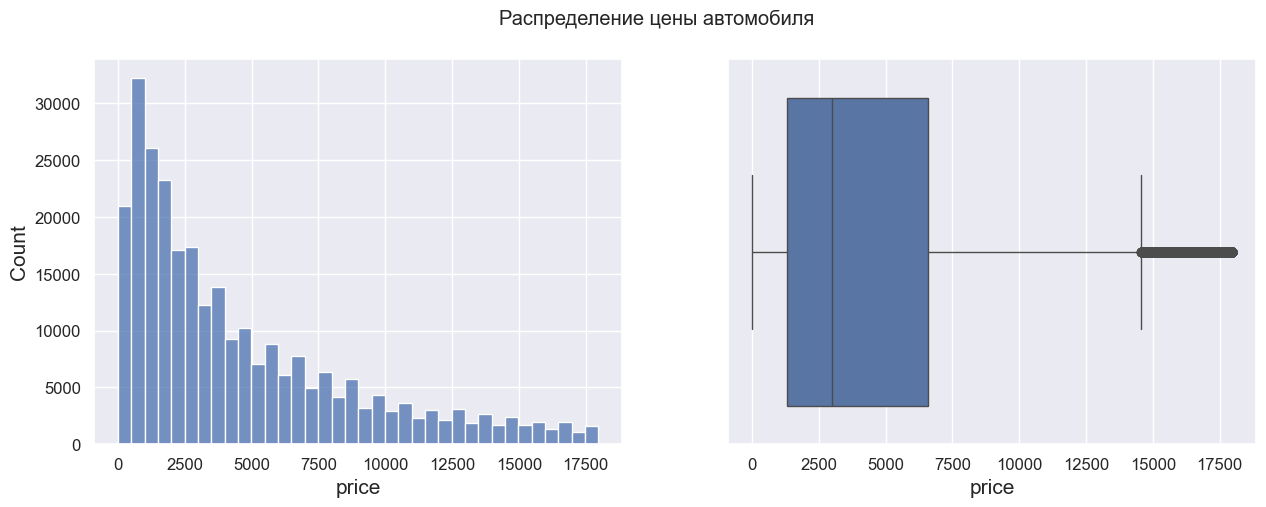

In [29]:
# взглянем на распределение цены на графике
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Распределение цены автомобиля')
sns.histplot(df_autos['price'], bins=36, ax=ax[0])
sns.boxplot(x=df_autos['price'], ax=ax[1])
plt.show()

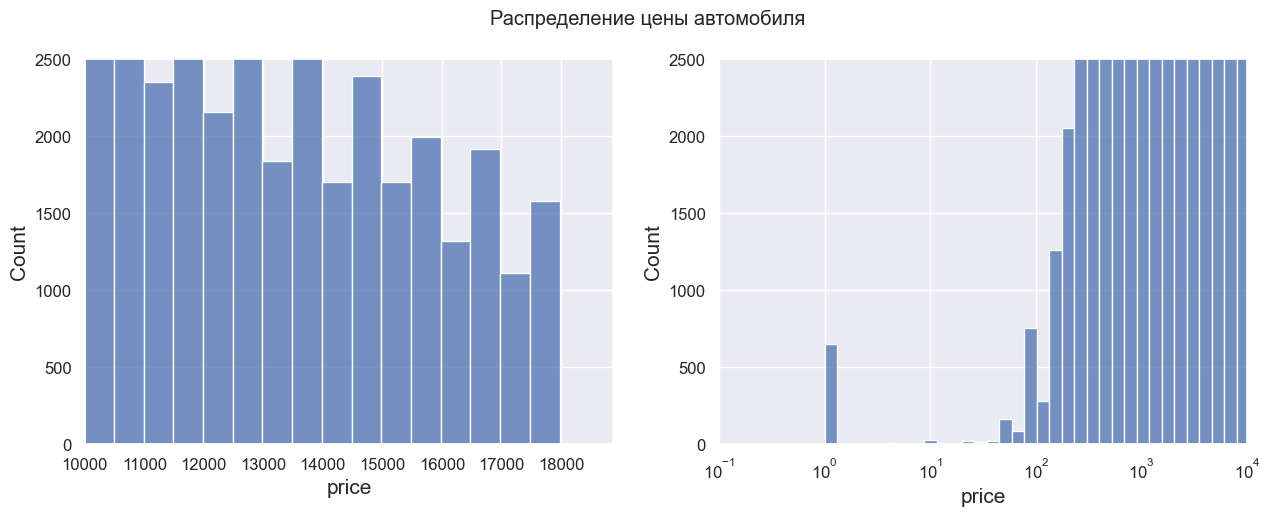

In [30]:
# увеличим масштаб
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Распределение цены автомобиля')
sns.histplot(df_autos['price'], bins=36, ax=ax[0])
sns.histplot(df_autos['price'], bins=36, log_scale=True, ax=ax[1])
ax[0].set_xlim(1e4)
ax[0].set_ylim(0,2.5e3)
ax[1].set_xlim(0.1,1e4)
ax[1].set_ylim(0,2.5e3)
plt.show()

In [31]:
# удалим редкие значения
df_autos.drop(df_autos[(df_autos['price'] < 100) | (df_autos['price'] > 15000)].index, inplace=True)

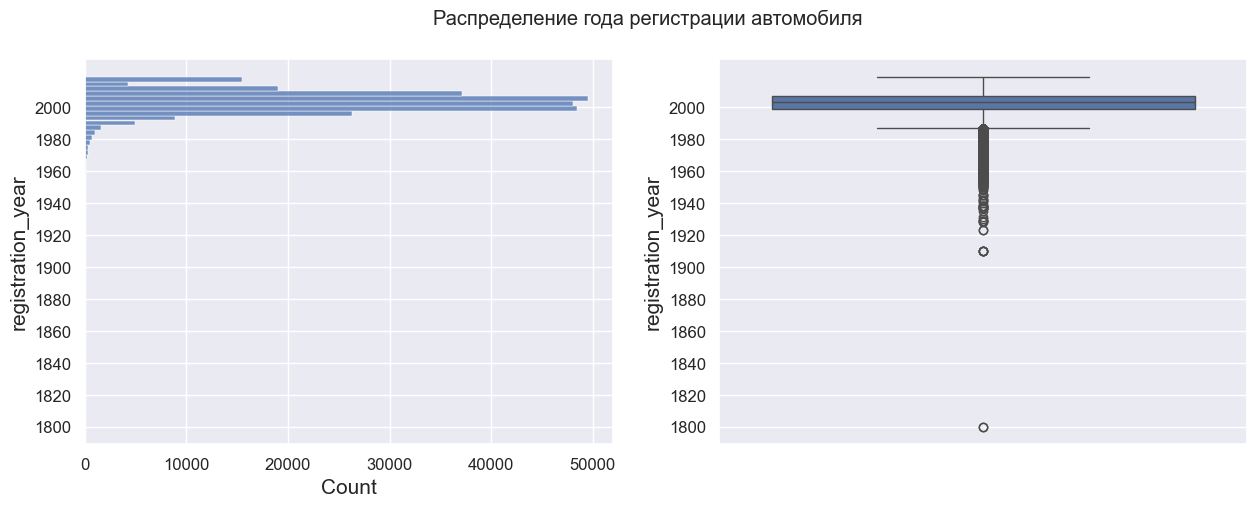

In [32]:
# построим распределение года регистрации автомобиля и рассмотрим левый хвост
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Распределение года регистрации автомобиля')
sns.histplot(y=df_autos['registration_year'], bins=72, ax=ax[0])
ax[0].set_yticks(range(1800,2020,20))
sns.boxplot(y=df_autos['registration_year'], ax=ax[1])
# ax[1].set_ylim(1900,2000)
ax[1].set_yticks(range(1800,2020,20))
# ax[1].set_xlim(0,4000)
plt.show()

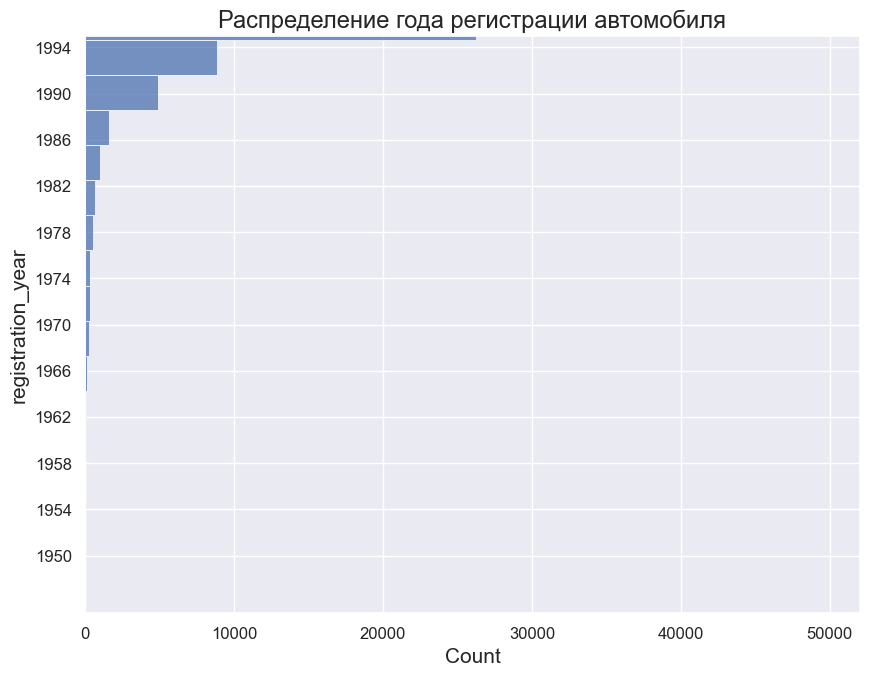

In [33]:
# построим распределение года регистрации автомобиля и рассмотрим левый хвост
sns.histplot(y=df_autos['registration_year'], bins=72)
plt.title('Распределение года регистрации автомобиля')
plt.ylim(1945, 1995)
plt.yticks(range(1950,1996, 4));

In [34]:
# удалим редкие значения
df_autos.drop(df_autos[(df_autos['registration_year'] <= 1990) | (df_autos['registration_year'] > 2016)].index, inplace=True)

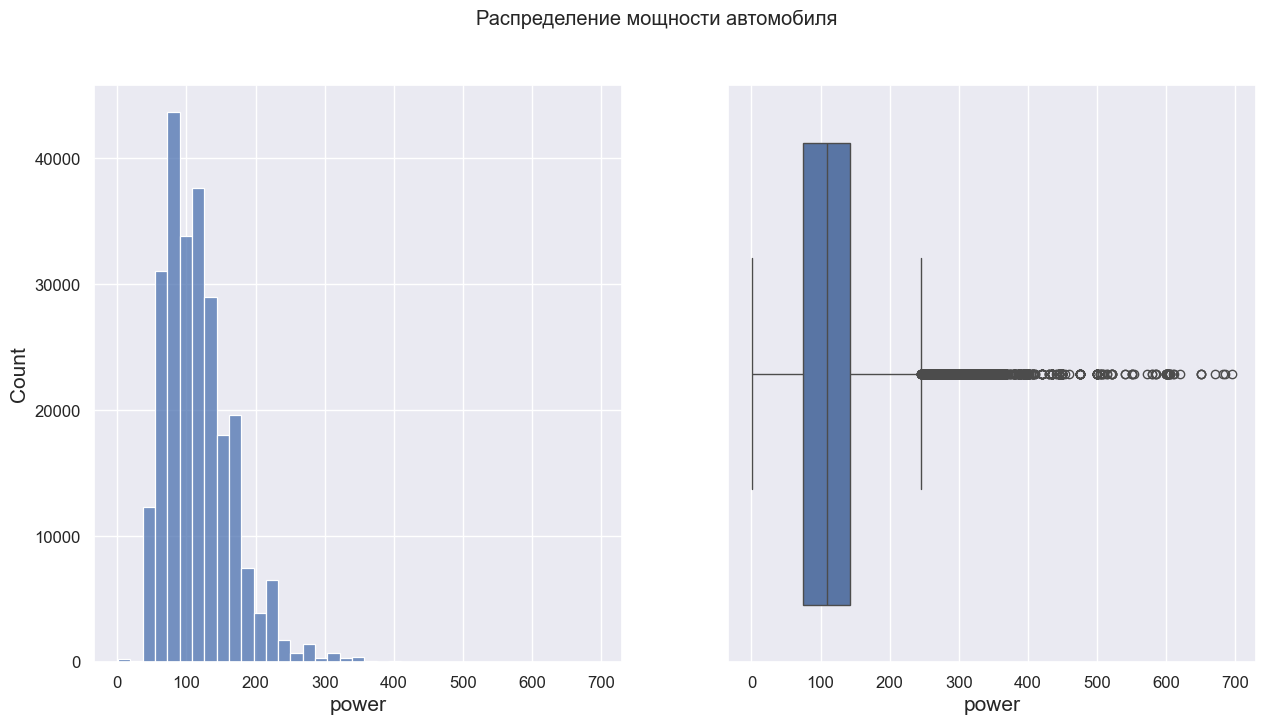

In [35]:
# построим распределение мощности авто
fig, ax = plt.subplots(1,2,figsize=(15,7.5))
fig.suptitle('Распределение мощности автомобиля')
sns.histplot(x=df_autos['power'], bins=39, ax=ax[0])
sns.boxplot(x=df_autos['power'], ax=ax[1])
plt.show()

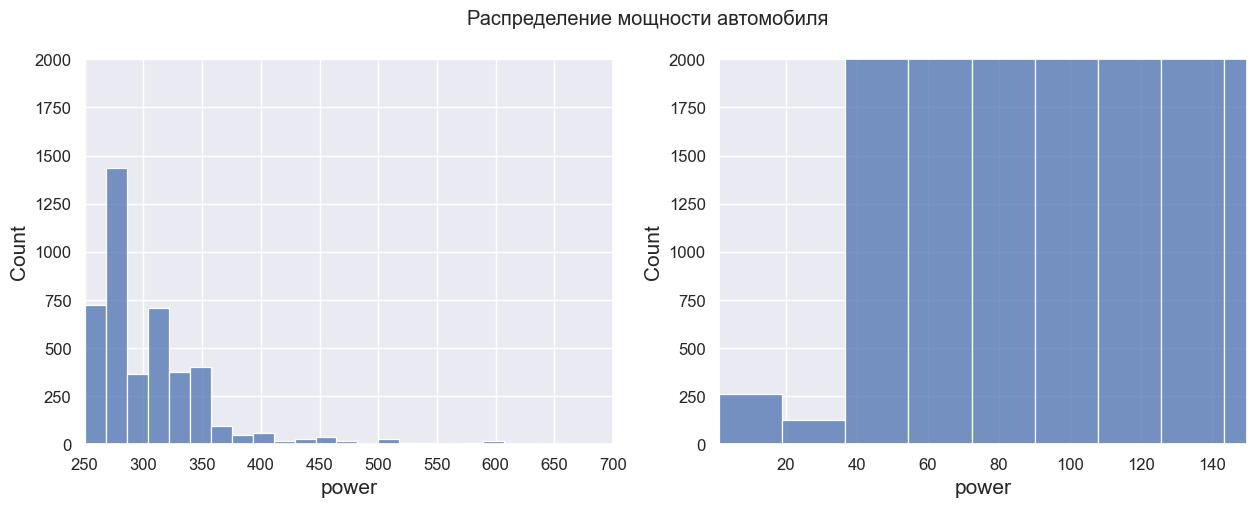

In [36]:
# рассмотрим хвосты
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Распределение мощности автомобиля')
sns.histplot(df_autos['power'], bins=39, ax=ax[0])
sns.histplot(df_autos['power'], bins=39, ax=ax[1])
ax[0].set_xlim(250,700)
ax[0].set_ylim(0,2000)
ax[1].set_xlim(1,1.5e2)
ax[1].set_ylim(0,2000)
plt.show()

In [37]:
# удалим редкие значения
df_autos.drop(df_autos[(df_autos['power'] < 40) | (df_autos['power'] > 300)].index, inplace=True)

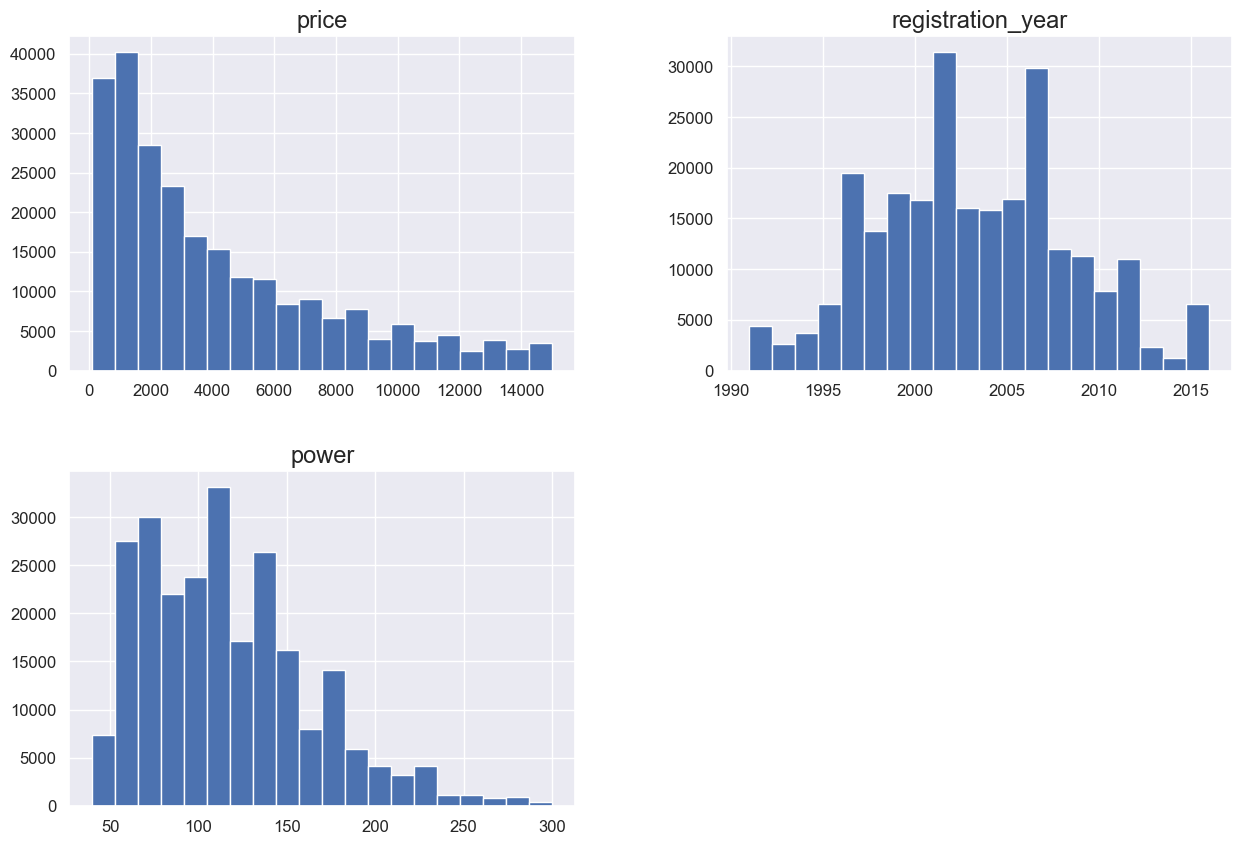

In [38]:
# построим гистограммы распределения после удаления редких значений
df_autos[l_numerics].hist(bins=20, figsize=(15,10));

In [39]:
df_autos[l_numerics].describe()

,price,registration_year,power
count,247257.000000,247257.000000,247257.000000
mean,4180.593811,2003.097300,116.293893
std,3685.389325,5.333546,46.837953
min,100.000000,1991.000000,40.000000
25%,1250.000000,1999.000000,75.000000
50%,2900.000000,2003.000000,109.000000
75%,6200.000000,2007.000000,143.000000
max,15000.000000,2016.000000,300.000000


In [40]:
f'data loss {(354369 - 247257) / 354369 * 100:.1f}%'

'data loss 30.2%'

---

#### Категориальные данные

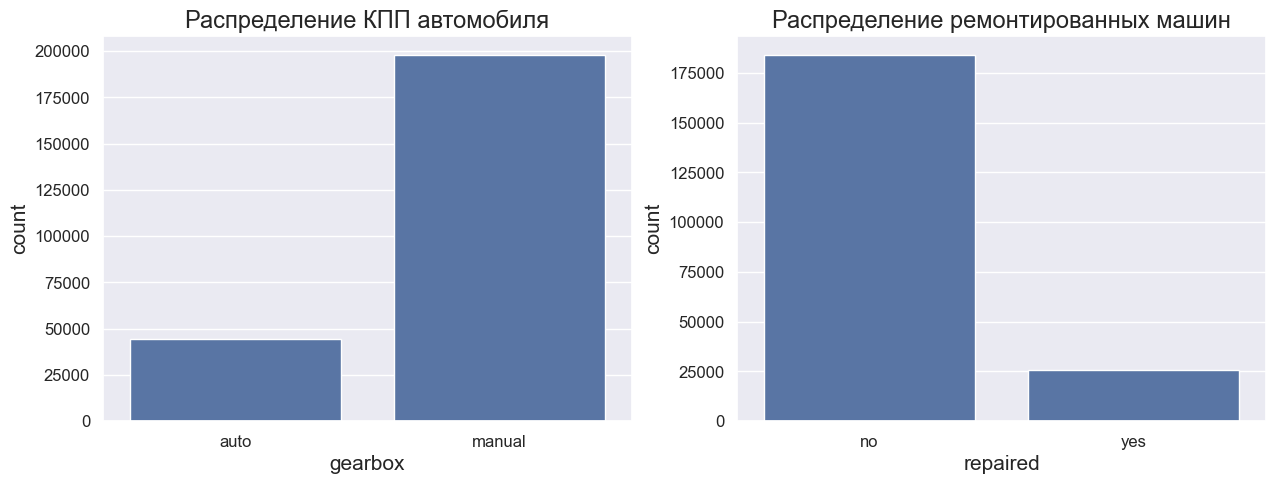

In [41]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
# построим распределение типа кузова
sns.countplot(x=df_autos.gearbox, ax=ax[0])
ax[0].set_title('Распределение КПП автомобиля');
# построим распределение авто по ремонту
sns.countplot(x=df_autos.repaired, ax=ax[1])
ax[1].set_title('Распределение ремонтированных машин');

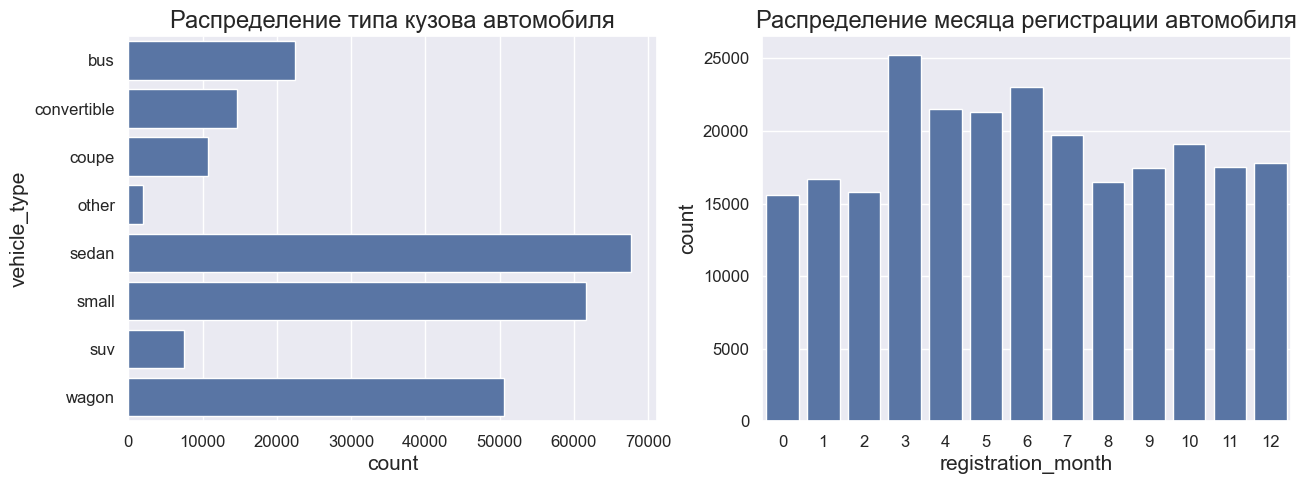

In [42]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

# построим распределение авто по ремонту
sns.countplot(y=df_autos.vehicle_type, ax=ax[0])
ax[0].set_title('Распределение типа кузова автомобиля')

# построим распределение авто по ремонту
sns.countplot(x=df_autos.registration_month, ax=ax[1])
ax[1].set_title('Распределение месяца регистрации автомобиля');

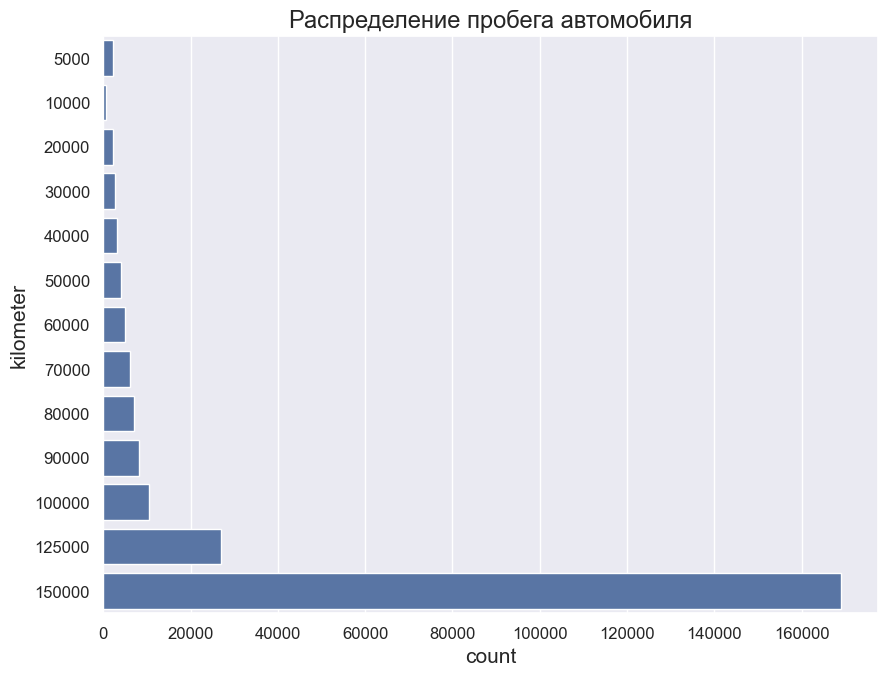

In [43]:
# построим распределение авто по ремонту
sns.countplot(y=df_autos.kilometer)
plt.title('Распределение пробега автомобиля');

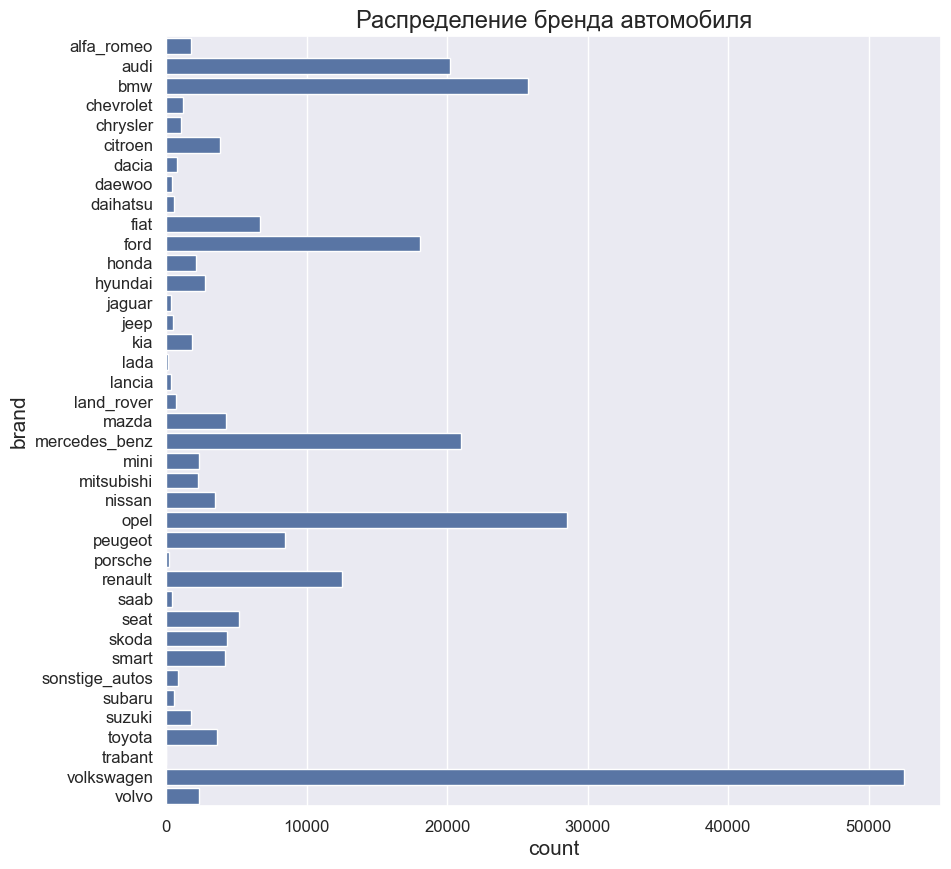

In [44]:
# построим распределение авто по ремонту
plt.figure(figsize=(10,10))
sns.countplot(y=df_autos.brand)
plt.title('Распределение бренда автомобиля');

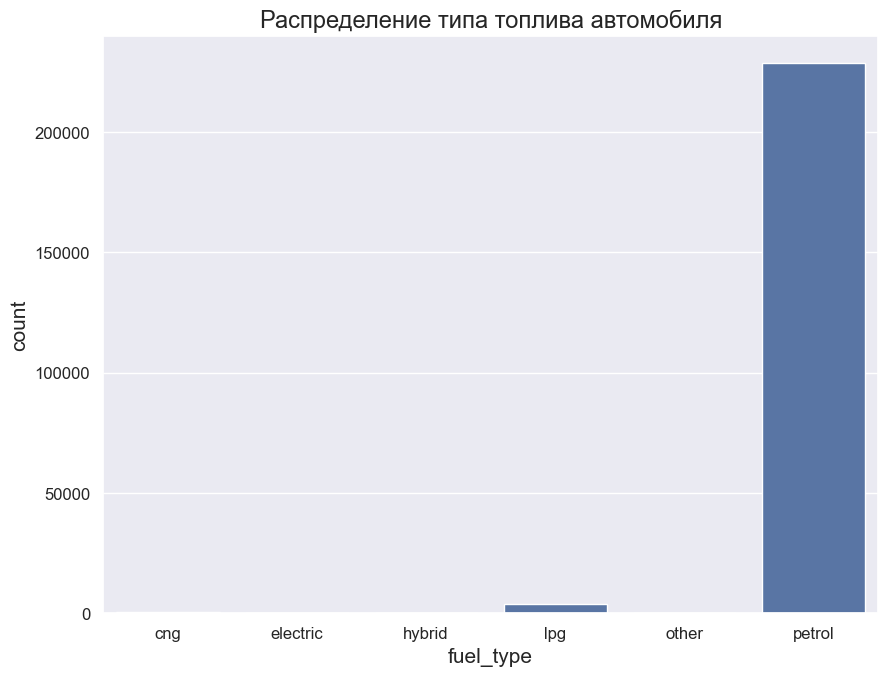

In [45]:
# построим распределение авто по ремонту
sns.countplot(x=df_autos.fuel_type)
plt.title('Распределение типа топлива автомобиля');

In [46]:
del fig, ax

---
---

### Корреляционный анализ данных

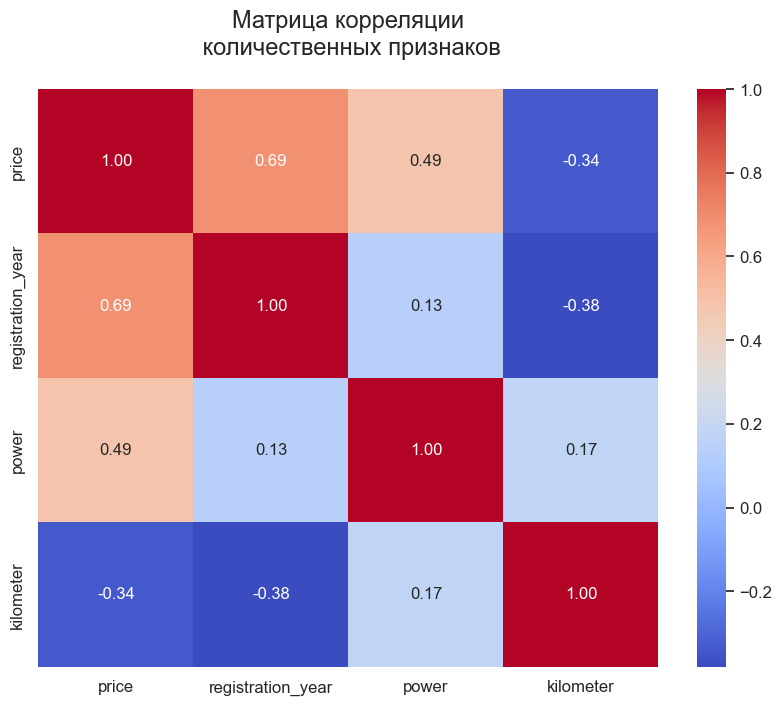

In [47]:
# матрица корреляций
corr_m = df_autos.corr(method='spearman')

# визуализируем ее сиборном
sns.heatmap(corr_m, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции\n количественных признаков\n')
plt.show()

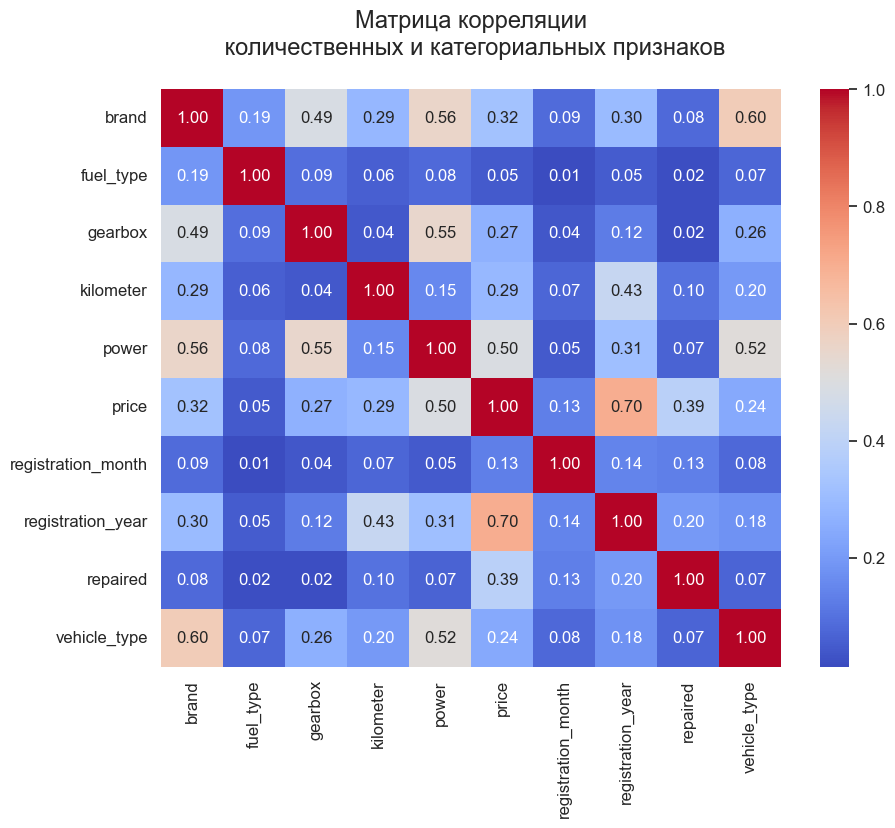

In [48]:
phik_m = df_autos.sort_index(axis=1).phik_matrix(interval_cols=['price', 'registration_year', 'power', 'kilometer'])

sns.heatmap(phik_m, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляции\n количественных и категориальных признаков\n')
plt.show()

In [49]:
del corr_m, phik_m

Проверим возможность уменьшения размера данных.

In [50]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [51]:
df_autos = optimize_memory_usage(df_autos)

Размер использования памяти: до 18.91 Mb - после 13.72 Mb (27.4%)


Отделим признаки от таргета.

In [52]:
features = df_autos.drop('price', axis=1)
target = df_autos['price']

### Выводы

1. Были загружены данные, в которых содержалось 16 колонок, в данных обнаружены пропуски.


2. Были отобраны признаки: 
    * данные, содержащие дату были удалены, так как были неинформативны для обучения моделей; 
    * был удален признак, содержащий почтовый индекс, так как для обучения модели он не понадобится, также он содержал много уникальных значений;
    * был удален признак с кол-вом фотографий в объявлении, так как он содержал только одно уникальное значение;
    * был удален признак, содержащий модель авто, так этот признак сильно коррелировал с брендом авто и содержал много уникальных значений.
    
    
3. Были обработаны неявные дубликаты в категориальных данных и удалены явные дубликаты.


4. Данные были правильно типизированы, так все строковые значения и данные с месяцем регистрации авто были типизированы как категориальные.


5. Во время исследовательского анализа данных были удалены редкие и выбивающиеся значения таких количественных признаков, как 
    * цена автомобиля;
    * год регистрации авто;
    * мощность ТС.
    
    
6. Во время исследования категориальных признаков было выявлено значительное превалирование:
    * авто с пробегом более 150000 км;
    * авто с ДВС (бензиновых автомобилей);
    * автомобилей бренда volkswagen;
    * авто с МКПП;
    * авто, которые не были в ремонте.
    
    
7. Корреляционный анализ данных не выявил наличия линейной или нелинейной зависимости между оставшимися признаками.


8. Оптимизация уменьшила размер данных с 18.91 Mb до 13.72 Mb (на 27.4%).

---
---
---

## Обучение моделей

### Подготовка данных

In [53]:
# разделим данные на тренировочную и тестовую выборку
# стратифицируем по бренду
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = features['brand'])
# выведем размерности выборок
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((185442, 9), (61815, 9), (185442,), (61815,))

In [54]:
num_columns = ['registration_year', 'power']
cat_columns = ['vehicle_type', 'gearbox', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired']

ohe_columns = ['vehicle_type', 'gearbox', 'brand', 'registration_month', 'fuel_type']
ord_columns = ['kilometer', 'repaired']

In [55]:
# заполнение пропусков SimpleImputer() + кодирование OneHotEncoder()
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe_nan', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

In [56]:
# заполнение пропусков SimpleImputer + кодирование OrdinalEncoder() + заполнение пропусков SimpleImputer
ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            categories=[
                [150000, 125000, 100000, 90000, 80000, 70000, 60000, 50000, 40000, 30000, 20000, 10000, 5000],
                ['yes', 'no']
            ],
            handle_unknown='use_encoded_value',
            unknown_value=np.nan)),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [57]:
# подготовка данных для нелинейной модели
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [58]:
# подготовка данных для линейной модели
data_preprocessor_lr = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [59]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor_lr),
        ('model', DummyRegressor())
    ]
)

---
---

### DummyRegressor()

In [60]:
print('Обучение модели:')
pipe_final.fit(X_train, y_train)
print(f'RMSE Train: {np.power(mean_squared_error(y_train, pipe_final.predict(X_train)),0.5):.2f}')

Обучение модели:
RMSE Train: 3682.72


Предсказание средним с помощью DummyRegressor() не соответствует требованию качества предсказаний, опробуем другие модели.

---
---

In [61]:
def gscv_fit(pipe, param_grid):
    '''
    return best model of OptunaSerchCV().fit(X_train, y_train)
    '''
    gscv = GridSearchCV(
        pipe, param_grid, scoring='neg_root_mean_squared_error',
        cv=3, n_jobs=-1, verbose=0, refit=True
    )
    
    print('Кросс-валидация и подбор гиперпараметров:')
    gscv.fit(X_train, y_train)
    print(f'CV-RMSE Train: {-gscv.best_score_:.2f}\n')
    print(f'Best estimator refit time: {gscv.refit_time_} sec')
    
    return gscv

### Ridge()

In [62]:
model_ridge = gscv_fit(
    
#     пайплаййн подготовки данных и модель l2-регуляризации
    pipe_final.set_params(preprocessor=data_preprocessor_lr, model=Ridge(random_state=RANDOM_STATE)), 
    
#     гиперпараметры для модели
    {'model__alpha': [i/100 for i in range(1, 500, 20)]}
)

Кросс-валидация и подбор гиперпараметров:
CV-RMSE Train: 2086.37

Best estimator refit time: 1.002274513244629 sec


Модель `Ridge` смогла подобрать такой параметр, чтобы метрика предсказания на тренировочных данных была менее 2500, время фитирования чуть больше 1 секунды.

---
---

Далее будут использоваться модели, которые не чувствительны к масштабу числовых характеристик, поэтому обновим пайплайн подготовки данных.

In [63]:
# подготовка данных для нелинейных моделей
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns)
    ],
    remainder='passthrough'
)

### DecisionTreeRegressor()

In [64]:
model_tree = gscv_fit(
    
#     пайнлайн подготовки данных и модель дерева решений
    pipe_final.set_params(
        preprocessor=data_preprocessor,
        model=DecisionTreeRegressor(random_state=RANDOM_STATE)
    ), 
    
#     гиперпараметры для модели
    {
        'model__min_samples_split': range(2, 12, 2),
        'model__min_samples_leaf': range(1, 11, 2)
    }
)

Кросс-валидация и подбор гиперпараметров:
CV-RMSE Train: 1481.02

Best estimator refit time: 2.8144896030426025 sec


Метрика модели `DecisionTreeRegressor` на тренировочных данных намного лучше, чем метрика модели `Ridge`, время фитирования модели 3.2 секунды.

---
---

### RandomForestRegressor()

In [65]:
model_forest = gscv_fit(
    
#     пайнлайн подготовки данных и модель дерева решений
    pipe_final.set_params(
        preprocessor=data_preprocessor,
        model=RandomForestRegressor(n_estimators=10, random_state=RANDOM_STATE, n_jobs=-1)
    ), 
    
#     гиперпараметры для модели
    {
        'model__min_samples_split': range(2, 17, 5),
        'model__min_samples_leaf': range(1, 16, 5)
    }
)

Кросс-валидация и подбор гиперпараметров:
CV-RMSE Train: 1405.69

Best estimator refit time: 6.1239073276519775 sec


Модель `RandomForestRegressor` чуть лучше справилась с предсказанием на тренировочной выборке (1406), чем модель `DecisionTreeRegressor` (1481), но время фитирования больше — 16.6 секунд против 3.2 секунд.

---
---

In [66]:
# Функция для удаления префиксов
def remove_prefixes(name):
    '''
    Remove 'ohe__', 'ord__', 'num__' prefixes in string
    ---------------------------------------------------
    Return updated string
    '''
    prefixes_to_remove = ['ohe__', 'ord__', 'num__']
    for prefix in prefixes_to_remove:
        name = name.replace(prefix, '')
    return name

### Градиентный бустинг LGBMModel()

In [67]:
data_preprocessor.fit(X_train)

feature_names = [remove_prefixes(name) for name in data_preprocessor.get_feature_names_out()]
cat_features = [el for el in feature_names if el not in num_columns]

X_train_transformed = pd.DataFrame(data_preprocessor.transform(X_train), columns=feature_names)
X_test_transformed = pd.DataFrame(data_preprocessor.transform(X_test), columns=feature_names)

train_dataset = lgb.Dataset(X_train_transformed, label=y_train, categorical_feature=cat_features, feature_name=feature_names)
test_dataset = lgb.Dataset(X_test_transformed, label=y_test, categorical_feature=cat_features, feature_name=feature_names)

In [68]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'reg_lambda': 0.
         }

In [69]:
cv_results = lgb.cv(
    params,
    train_dataset,
    categorical_feature=cat_features,
    feature_name=feature_names,
    num_boost_round=2000,
    nfold=3,
    metrics='rmse',
    seed=0,
    callbacks=[lgb.early_stopping(stopping_rounds=20, first_metric_only=True)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 123628, number of used features: 66
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 123628, number of used features: 66
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data po

In [70]:
cv_results.keys()

dict_keys(['valid rmse-mean', 'valid rmse-stdv'])

In [71]:
booster = lgb.LGBMModel(n_estimators=len(cv_results['valid rmse-mean']), random_state=RANDOM_STATE, **params)

In [72]:
%time booster.fit(X_train_transformed, y_train, feature_name=feature_names, categorical_feature=cat_features)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 185442, number of used features: 66
[LightGBM] [Info] Start training from score 4177.809914
CPU times: total: 18.6 s
Wall time: 5.44 s


LGBMModel(metric='rmse', n_estimators=959, objective='regression',
          random_state=42)

Метрика градиентного бустинга меньше всех представленных моделей 1352, фремя фитирования модели самое длительное — 33 секунды.

---
---
---

## Анализ моделей

1. ***`DummyRegressor()`*** справился хуже всех моделей. Метрика RMSE больше **3500** на тренировочной выборке.


2. Модель ***`Ridge()`*** смогла подобрать подходящий параметр. Метрика **CV-RMSE = 2086**, время обучения модели **1 секунда**.


3. Модель дерева решений ***`DecisionTreeRegressor()`*** справилась с тренировочными данными с **CV-RMSE = 1481**, время обучения модели составило **3.2 секунды**.


4. Модель ***`RandomForestRegressor()`*** на тренировочных данных выдала **CV-RMSE = 1406**, время обучения составило **16.6 секунд**.


5. Градиентный бустинг с помощью ***`LGBMModel(objective='regressor')`*** выдал метрику **CV-RMSE = 1352** на тренировочной выборке, время обучения составило **33 секунды**.

Среди всех представленных моделей градиентный бустинг демонстрирует лучшую метрику, однако обучение этой модели происходит медленнее, чем у остальных. В то же время модель рандомного леса демонстрирует метрику, близкую к бустингу, но обучение проходит в два раза быстрее.

Важными критериями отбора моделей МО являются: качество и скорость предсказания, скорость обучения модели.

Таким образом, с поставленной задачей предсказания цены автомобилей лучше стравится модель рандомного леса.

### Предсказания на тестовых данных

In [73]:
preds = model_forest.predict(X_test)

print(f'RMSE Test: {np.power(mean_squared_error(y_test, preds), 0.5):.2f}\n')

RMSE Test: 1371.21



Модель рандомного леса сработала на тестовых данных достаточно хорошо — метрика равна 1371.

---
---

## Итоговые выводы